In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import datetime

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station=Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Using the inspector to print the column names within the 'dow' table and its types
# Create the inspector and connect it to the engine
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x2b14bf94ee0>,
 'prcp': 2.0,
 'id': 0,
 'station': 'USC00519397',
 'date': '2010-01-01',
 'tobs': 18.3}

In [11]:
# Find the most recent date in the data set.
rows=session.query(func.max(Measurement.date)).first()
recent_date=rows[0]

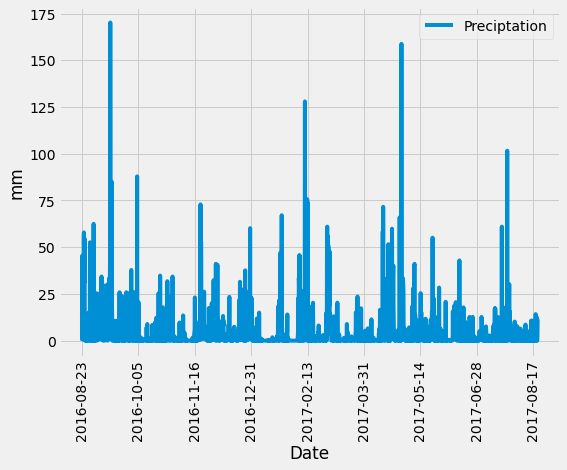

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
recentdate=datetime.strptime(recent_date,"%Y-%m-%d")

# Calculate the date one year from the last date in data set.
year_ago = recentdate - dt.timedelta(days=366)

# Perform a query to retrieve the data and precipitation scores
sel = [Measurement.date, Measurement.prcp]
prcp = session.query(*sel).filter(Measurement.date > year_ago).\
    filter(Measurement.date <= recentdate).all()
date_list=[]
prcp_list=[]
for record in prcp:
    (mea_date, mea_prcp) = record
    date_list.append(mea_date)
    prcp_list.append(mea_prcp)

# Save the query results as a Pandas DataFrame and set the index to the date column
data = {'Date':date_list, 'Preciptation':prcp_list}
df=pd.DataFrame(data)
df.set_index('Date',inplace=True)

# Sort the dataframe by date
df.sort_values('Date',inplace=True,ascending=True)
df.dropna(inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
df.plot(figsize=(8,6),rot=90)
plt.ylabel("mm")
plt.xlabel("Date")
plt.show()

In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,Preciptation
count,2021.000000
mean,4.505888
std,11.713487
min,0.000000
25%,0.000000
50%,0.500000
75%,3.300000
max,170.200000


# Exploratory Station Analysis

In [16]:
# Design a query to calculate the total number stations in the dataset
inspector = inspect(engine)
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [17]:
# Total number stations
rows=session.query(func.count(Station.station)).first()
for station_number in rows:
   print(f"Totle number of stations is {station_number}.")

Totle number of stations is 9.


In [18]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
from sqlalchemy import desc

sel = [Station.name, Station.station, func.count(Measurement.station)]
rows=session.query(*sel).\
    filter(Station.station==Measurement.station).\
    group_by(Station.name).\
    order_by(desc(func.count(Measurement.station))).\
    all()

for record in rows:
    (st_name, st_station, most_active) = record
    print(f'The station "{st_name}", id is {st_station}, counts is {most_active}.')

The station "WAIHEE 837.5, HI US", id is USC00519281, counts is 2772.
The station "WAIKIKI 717.2, HI US", id is USC00519397, counts is 2724.
The station "KANEOHE 838.1, HI US", id is USC00513117, counts is 2709.
The station "WAIMANALO EXPERIMENTAL FARM, HI US", id is USC00519523, counts is 2669.
The station "MANOA LYON ARBO 785.2, HI US", id is USC00516128, counts is 2612.
The station "KUALOA RANCH HEADQUARTERS 886.9, HI US", id is USC00514830, counts is 2202.
The station "HONOLULU OBSERVATORY 702.2, HI US", id is USC00511918, counts is 1979.
The station "PEARL CITY, HI US", id is USC00517948, counts is 1372.
The station "UPPER WAHIAWA 874.3, HI US", id is USC00518838, counts is 511.


In [19]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
(st_name, st_station, most_active) = rows[0]

sel = [func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)]
rows1=session.query(*sel).\
    filter(Station.station==Measurement.station).\
    filter(Station.name == st_name).\
    all()

for record in rows1:
    (min_temp, max_temp, avg_temp) = record
    print(f'The lowest temperature in "{st_name}" is {min_temp:.1f} ℃.')
    print(f'The highest temperature in "{st_name}" is {max_temp:.1f} ℃.')
    print(f'The average temperature in "{st_name}" is {avg_temp:.1f} ℃.')

The lowest temperature in "WAIHEE 837.5, HI US" is 12.2 ℃.
The highest temperature in "WAIHEE 837.5, HI US" is 29.4 ℃.
The average temperature in "WAIHEE 837.5, HI US" is 22.0 ℃.


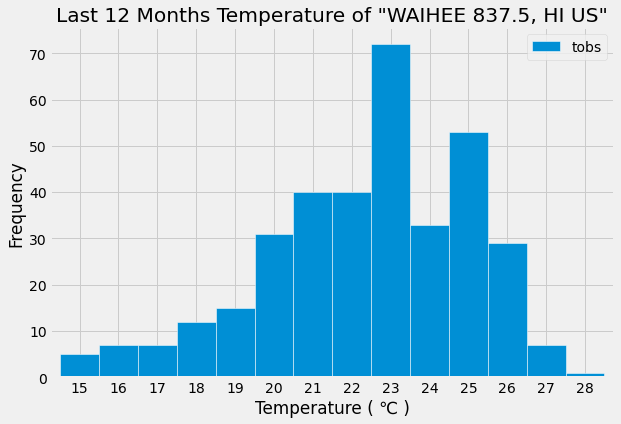

In [20]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
df1 = pd.read_sql_query(
    sql = session.query(Measurement.tobs).\
        filter(Measurement.date > year_ago).\
        filter(Measurement.date <= recentdate).\
        filter(Measurement.station == Station.station).\
        filter(Station.name == st_name).statement,
    con = engine
)

# Set bins and value counts
bins=np.arange(15)+15
segments=pd.cut(df1['tobs'],bins,right=False)
counts=pd.value_counts(segments,sort=False)

# Draw the plot
plt.figure(figsize=(9,6))
ax=counts.plot.bar(title=f'Last 12 Months Temperature of "{st_name}"',xlabel='Temperature ( ℃ )',ylabel='Frequency',width=1,edgecolor='white',rot=0)

# Set xtick lables to bins
ax.set_xticklabels(bins[0:14])

# Set legend
ax.legend()
plt.show()

# Close session

In [21]:
# Close Session
session.close()